In [1]:
#!pip install krippendorff

In [2]:
import os
import pandas as pd
import numpy as np
import traceback
import json
import math 

from functools import partial
import matplotlib.pyplot as plt

try:
    import krippendorff as kd
    import seaborn as sns
    sns.set()
except:
    pass




In [3]:
!tree

/home/maxku/.bashrc: line 17: genv: command not found
.
├── AnalyzeHumanEval.ipynb
├── Control-Guided_IG
│   ├── Control-Guided_IG_rater1.tsv
│   ├── Control-Guided_IG_rater2.tsv
│   └── Control-Guided_IG_rater3.tsv
├── Mask-Guided_IE
│   ├── Mask-Guided_IE_rater1.tsv
│   ├── Mask-Guided_IE_rater2.tsv
│   └── Mask-Guided_IE_rater3.tsv
├── Multi-Subject_IG
│   ├── Multi-Subject_IG_rater1.tsv
│   ├── Multi-Subject_IG_rater2.tsv
│   └── Multi-Subject_IG_rater3.tsv
├── plot_SD.png
├── Subject-Driven_IE
│   ├── Subject-Driven_IE_rater1.tsv
│   ├── Subject-Driven_IE_rater2.tsv
│   └── Subject-Driven_IE_rater3.tsv
├── Subject-Driven_IG
│   ├── Subject-Driven_IG_rater1.tsv
│   ├── Subject-Driven_IG_rater2.tsv
│   └── Subject-Driven_IG_rater3.tsv
├── Text-Guided_IE
│   ├── Text-Guided_IE_rater1.tsv
│   ├── Text-Guided_IE_rater2.tsv
│   └── Text-Guided_IE_rater3.tsv
└── Text-To-Image
    ├── Text-To-Image_rater1.tsv
    ├── Text-To-Image_rater2.tsv
    └── Text-To-Image_rater3.tsv

7 directories

In [4]:


def grab_dataframes(root_dir = '.'):
    # Initialize an empty dictionary to store dataframes
    dataframes_dict = {}

    # List all subdirectories in the root directory
    subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    # Iterate through each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(root_dir, subdir)

        # Forget about ipynb things
        if subdir == ".ipynb_checkpoints":
            continue
        # Initialize a list for dataframes in this directory
        dir_dataframes = []

        # Walk through the current subdirectory
        for root, _, files in os.walk(subdir_path):
            for file in files:
                # Check if the file has a .tsv extension
                if file.endswith('.tsv'):
                    # Create the full path to the TSV file
                    tsv_path = os.path.join(root, file)

                    # Read the TSV file into a pandas dataframe
                    df = pd.read_csv(tsv_path, sep='\t')

                    # Append the dataframe to the list for this directory
                    dir_dataframes.append(df)

        # Add the list of dataframes to the dictionary with the subdirectory name as the key
        dataframes_dict[subdir] = dir_dataframes

    # Now you have a dictionary where keys are subdirectory names and values are lists of TSV dataframes
    return dataframes_dict


def process(one_df, mapping_dict=None):
    df = one_df.drop(one_df.columns[0],axis=1) # Dropping uid column
    #print(df.columns)
    result_dict = {}
    
    def get_SC_from_cell(cell, return_cell_index=0, mapping = {0: 0, 0.5: 0.5, 1: 1}):
        #print(cell)
        if isinstance(cell, str):
            cell = eval(cell)
        if mapping is not None:
            cell = [mapping[value] for value in cell]
        assert len(cell) == 2
            
        return cell[return_cell_index]

    get_PR_from_cell = partial(get_SC_from_cell, return_cell_index=1)


    def get_HumanEval_score_from_cell(cell, mapping = {0: 0, 0.5: 0.5, 1: 1}, method = "geometric_mean", alpha=0.7, beta=0.3):
        if isinstance(cell, str):
            cell = eval(cell)
        if mapping is not None:
            cell = [mapping[value] for value in cell]
        if method == "geometric_mean":
            human_score = cell[0]*cell[1]
            human_score = math.sqrt(human_score)
        else:
            human_score = alpha*cell[0]+beta*cell[1]
        return human_score
    
    for column in df.columns:
        SC_scores = [get_SC_from_cell(x) for x in df[column]]
        PR_scores = [get_PR_from_cell(x) for x in df[column]]
        HumanEval_scores = [get_HumanEval_score_from_cell(x) for x in df[column]]
        SC_mean = float(sum(SC_scores)) / len(SC_scores)
        PR_mean = float(sum(PR_scores)) / len(PR_scores)
        SC_std = np.std(SC_scores)
        PR_std = np.std(PR_scores)
        result_dict[column] = {'SC': SC_scores, 
                               'PR': PR_scores, 
                               'SC_avg': SC_mean,
                               'PR_avg': PR_mean,
                               'SC_std': SC_std,
                               'PR_std': PR_std,
                               'HumanEval': HumanEval_scores,
                               'HumanEvalSum': sum(HumanEval_scores),
                               'HumanEvalAvg': sum(HumanEval_scores) / len(HumanEval_scores),
                              }
    return result_dict

def combine_result_dicts(result_dicts_list, apply_average=False):
    """
    combining result dictionaries into one.
    """
    assert isinstance(result_dicts_list, list)
    assert len(result_dicts_list) > 1
    report_dict = {}
    first_result_dict = result_dicts_list[0]
    result_dicts_list.pop(0) # remove first
    for column, value in first_result_dict.items():
        report_dict[column] = {'SC': [ first_result_dict[column]['SC'] ], 
                               'PR': [ first_result_dict[column]['PR'] ], 
                               'SC_avg': [ first_result_dict[column]['SC_avg'] ],
                               'PR_avg': [ first_result_dict[column]['PR_avg'] ],
                               'SC_std': [ first_result_dict[column]['SC_std'] ],
                               'PR_std': [ first_result_dict[column]['PR_std'] ],
                               'HumanEval': [ first_result_dict[column]['HumanEval'] ],
                               'HumanEvalSum': [ first_result_dict[column]['HumanEvalSum'] ],
                               'HumanEvalAvg': [ first_result_dict[column]['HumanEvalAvg'] ],
                              }
    
    for result_dict in result_dicts_list:
        for column, value in result_dict.items():
            report_dict[column]['SC'].append(result_dict[column]['SC'])
            report_dict[column]['PR'].append(result_dict[column]['PR'])
            report_dict[column]['SC_avg'].append(result_dict[column]['SC_avg'])
            report_dict[column]['PR_avg'].append(result_dict[column]['PR_avg'])
            report_dict[column]['SC_std'].append(result_dict[column]['SC_std'])
            report_dict[column]['PR_std'].append(result_dict[column]['PR_std'])
            report_dict[column]['HumanEval'].append(result_dict[column]['HumanEval'])
            report_dict[column]['HumanEvalSum'].append(result_dict[column]['HumanEvalSum'])
            report_dict[column]['HumanEvalAvg'].append(result_dict[column]['HumanEvalAvg'])


    if apply_average:
        for column, value in report_dict.items():
            #print(column)
            report_dict[column]['SC_std'] = np.std(report_dict[column]['SC_avg'])
            report_dict[column]['PR_std'] = np.std(report_dict[column]['PR_avg'])
            report_dict[column]['HumanEval_std'] = np.std(report_dict[column]['HumanEvalAvg'])
            report_dict[column]['SC'] = np.average(np.array(report_dict[column]['SC']), axis=0)
            report_dict[column]['PR'] = np.average(np.array(report_dict[column]['PR']), axis=0)
            report_dict[column]['SC_avg'] = np.average(np.array(report_dict[column]['SC_avg']), axis=0)
            report_dict[column]['PR_avg'] = np.average(np.array(report_dict[column]['PR_avg']), axis=0)
            report_dict[column]['HumanEval'] = np.average(np.array(report_dict[column]['HumanEval']), axis=0)
            report_dict[column]['HumanEvalSum'] = np.average(np.array(report_dict[column]['HumanEvalSum']), axis=0)
            report_dict[column]['HumanEvalAvg'] = np.average(np.array(report_dict[column]['HumanEvalAvg']), axis=0)
    return report_dict


def get_final_dicts(unprocessed_dataframes, apply_average=False):
    if len(unprocessed_dataframes) == 1:
        for raw_df in unprocessed_dataframes:
            return process(raw_df)
    result_dicts_list = []
    for raw_df in unprocessed_dataframes:
        result_dicts_list.append(process(raw_df))
    return combine_result_dicts(result_dicts_list, apply_average=apply_average)


def sigfig(number, sigfigs=2, digit_mode=True):
    if digit_mode:
        string_mode = '{:#.{sigfigs}f}'
    else:
        string_mode = '{:#.{sigfigs}g}'
    if isinstance(number, list):
        new_numbers = []
        for num in number:
            new_num = string_mode.format(num, sigfigs=sigfigs)
            new_numbers.append(float(new_num))
        return new_numbers
    else:
        return float(string_mode.format(number, sigfigs=sigfigs))

def print_all_results(dataframes, apply_average=False):
    out = dataframes
    for task_name in out.keys():
        print("=====================>", task_name)
        result = out[task_name]
        if len(result) >= 1:
            result = get_final_dicts(result, apply_average=apply_average)
            for model_name in result.keys():
                print("==>", model_name, ": ")
                print('====> SC_avg | ', sigfig(result[model_name]['SC_avg']))
                print('====> PR_avg | ', sigfig(result[model_name]['PR_avg']))
                print('====> HumanEvalSum | ', sigfig(result[model_name]['HumanEvalSum']))
                print('====> HumanEvalAvg | ', sigfig(result[model_name]['HumanEvalAvg']))
                if apply_average:
                    print('====> SC_std | ', sigfig(result[model_name]['SC_std']))
                    print('====> PR_std | ', sigfig(result[model_name]['PR_std']))
                    print('====> HumanEval_std | ', sigfig(result[model_name]['HumanEval_std']))
        else:
            print(task_name, "| No human eval results yet")
        print("")


In [5]:
def get_one_model_dict(task_name, model_name):
    return get_final_dicts(grab_dataframes()[task_name], apply_average=False)[model_name]

def get_fleiss_kappa(np_scores, method="fleiss"):
    """
    columns as raters
    """
    from statsmodels.stats import inter_rater as irr
    agg = irr.aggregate_raters(np_scores) # returns a tuple (data, categories)
    kappa = irr.fleiss_kappa(agg[0], method=method)
    return agg, kappa

def print_kappa_result(stats, method="fleiss"):
    stats = np.array(stats)
    stats = stats.T
    agg, kappa = get_fleiss_kappa(stats, method=method)
    print("Kappa | ", sigfig(kappa))

def print_kd_result(stats):
    stats = np.array(stats)
    kd_value = kd.alpha(stats, level_of_measurement='ordinal')
    print("Kd | ", sigfig(kd_value))

def print_all_kappa_results(dataframes, attr, method="fleiss"):
    out = dataframes
    for task_name in out.keys():
        print("=====================>", task_name)
        result = out[task_name]
        if len(result) >= 1:
            result = get_final_dicts(result, apply_average=False)
            for model_name in result.keys():
                try:
                    print("==>", model_name, ": ")
                    stats = result[model_name][attr]
                    print_kappa_result(stats, method=method)
                    print_kd_result(stats)
                except Exception as e:
                    print(e)
                    continue
        else:
            print(task_name, "| No Kappa results yet")
        print("")

In [6]:
print_all_results(grab_dataframes(), apply_average=False)

=====================> Control-Guided_IG
==> ControlNet : 
====> SC_avg |  [0.39, 0.38, 0.49]
====> PR_avg |  [0.14, 0.17, 0.24]
====> HumanEvalSum |  [27.25, 33.04, 42.54]
====> HumanEvalAvg |  [0.18, 0.22, 0.28]
==> UniControl : 
====> SC_avg |  [0.34, 0.32, 0.48]
====> PR_avg |  [0.13, 0.19, 0.28]
====> HumanEvalSum |  [22.59, 32.18, 47.92]
====> HumanEvalAvg |  [0.15, 0.21, 0.32]

=====================> Text-To-Image
==> DALLE : 
====> SC_avg |  [0.53, 0.64, 0.56]
====> PR_avg |  [0.58, 0.58, 0.7]
====> HumanEvalSum |  [96.68, 109.88, 113.57]
====> HumanEvalAvg |  [0.49, 0.56, 0.58]
==> DeepFloydIF : 
====> SC_avg |  [0.66, 0.67, 0.62]
====> PR_avg |  [0.58, 0.58, 0.71]
====> HumanEvalSum |  [113.25, 114.28, 121.67]
====> HumanEvalAvg |  [0.57, 0.58, 0.62]
==> OpenJourney : 
====> SC_avg |  [0.5, 0.55, 0.53]
====> PR_avg |  [0.59, 0.53, 0.65]
====> HumanEvalSum |  [94.61, 97.36, 106.01]
====> HumanEvalAvg |  [0.48, 0.49, 0.54]
==> SD : 
====> SC_avg |  [0.53, 0.58, 0.56]
====> PR_a

In [7]:
print_all_results(grab_dataframes(), apply_average=True)

=====================> Control-Guided_IG
==> ControlNet : 
====> SC_avg |  0.42
====> PR_avg |  0.19
====> HumanEvalSum |  34.28
====> HumanEvalAvg |  0.23
====> SC_std |  0.05
====> PR_std |  0.04
====> HumanEval_std |  0.04
==> UniControl : 
====> SC_avg |  0.38
====> PR_avg |  0.2
====> HumanEvalSum |  34.23
====> HumanEvalAvg |  0.23
====> SC_std |  0.07
====> PR_std |  0.06
====> HumanEval_std |  0.07

=====================> Text-To-Image
==> DALLE : 
====> SC_avg |  0.58
====> PR_avg |  0.62
====> HumanEvalSum |  106.71
====> HumanEvalAvg |  0.54
====> SC_std |  0.04
====> PR_std |  0.06
====> HumanEval_std |  0.04
==> DeepFloydIF : 
====> SC_avg |  0.65
====> PR_avg |  0.62
====> HumanEvalSum |  116.4
====> HumanEvalAvg |  0.59
====> SC_std |  0.02
====> PR_std |  0.06
====> HumanEval_std |  0.02
==> OpenJourney : 
====> SC_avg |  0.53
====> PR_avg |  0.59
====> HumanEvalSum |  99.33
====> HumanEvalAvg |  0.5
====> SC_std |  0.02
====> PR_std |  0.05
====> HumanEval_std |  0.02


In [8]:
print_all_kappa_results(grab_dataframes(), 'SC', 'fleiss')

=====================> Control-Guided_IG
==> ControlNet : 
Kappa |  0.42
Kd |  0.64
==> UniControl : 
Kappa |  0.45
Kd |  0.59

=====================> Text-To-Image
==> DALLE : 
Kappa |  0.37
Kd |  0.47
==> DeepFloydIF : 
Kappa |  0.53
Kd |  0.58
==> OpenJourney : 
Kappa |  0.46
Kd |  0.56
==> SD : 
Kappa |  0.55
Kd |  0.64
==> SDXL : 
Kappa |  0.49
Kd |  0.59
==> Midjourney : 
Kappa |  0.44
Kd |  0.57
==> DALLE3 : 
Kappa |  0.47
Kd |  0.55

=====================> Subject-Driven_IG
==> BLIPDiffusion_Gen : 
Kappa |  0.23
Kd |  0.39
==> DreamBooth : 
Kappa |  0.4
Kd |  0.64
==> DreamBoothLora : 
Kappa |  0.3
Kd |  0.38
==> SuTI : 
Kappa |  0.3
Kd |  0.53
==> TextualInversion : 
Kappa |  0.43
Kd |  0.58

=====================> Multi-Subject_IG
==> CustomDiffusion : 
Kappa |  0.83
Kd |  0.89
==> DreamBooth : 
Kappa |  0.65
Kd |  0.7
==> TextualInversion : 
Kappa |  0.73
Kd |  0.78

=====================> Mask-Guided_IE
==> BlendedDiffusion : 
Kappa |  0.44
Kd |  0.49
==> Glide : 
Kappa |  

/home/maxku/anaconda3/envs/aqua_canon/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:267: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


In [9]:
print_all_kappa_results(grab_dataframes(), 'PR', 'fleiss')

=====================> Control-Guided_IG
==> ControlNet : 
Kappa |  0.41
Kd |  0.55
==> UniControl : 
Kappa |  0.42


Kd |  0.59

=====================> Text-To-Image
==> DALLE : 
Kappa |  0.39
Kd |  0.42
==> DeepFloydIF : 
Kappa |  0.21
Kd |  0.21
==> OpenJourney : 
Kappa |  0.24
Kd |  0.29
==> SD : 
Kappa |  0.23
Kd |  0.24
==> SDXL : 
Kappa |  0.36
Kd |  0.43
==> Midjourney : 
Kappa |  0.05
Kd |  0.06
==> DALLE3 : 
Kappa |  0.06
Kd |  0.13

=====================> Subject-Driven_IG
==> BLIPDiffusion_Gen : 
Kappa |  0.12
Kd |  0.16
==> DreamBooth : 
Kappa |  0.39
Kd |  0.38
==> DreamBoothLora : 
Kappa |  0.36
Kd |  0.37
==> SuTI : 
Kappa |  0.24
Kd |  0.3
==> TextualInversion : 
Kappa |  0.24
Kd |  0.23

=====================> Multi-Subject_IG
==> CustomDiffusion : 
Kappa |  0.41
Kd |  0.41
==> DreamBooth : 
Kappa |  0.69
Kd |  0.69
==> TextualInversion : 
Kappa |  0.54
Kd |  0.56

=====================> Mask-Guided_IE
==> BlendedDiffusion : 
Kappa |  0.45
Kd |  0.55
==> Glide : 
Kappa |  0.28
Kd |  0.51
==> SDInpaint : 
Kappa |  0.26
Kd |  0.41
==> SDXLInpaint : 
Kappa |  0.42
Kd |  0.61

==========

In [10]:
print_all_kappa_results(grab_dataframes(), 'HumanEval', 'fleiss')

=====================> Control-Guided_IG
==> ControlNet : 
Kappa |  0.37
Kd |  0.57
==> UniControl : 
Kappa |  0.36
Kd |  0.58

=====================> Text-To-Image
==> DALLE : 
Kappa |  0.27
Kd |  0.4
==> DeepFloydIF : 
Kappa |  0.32
Kd |  0.51
==> OpenJourney : 
Kappa |  0.3
Kd |  0.47
==> SD : 
Kappa |  0.38
Kd |  0.5
==> SDXL : 
Kappa |  0.37
Kd |  0.61
==> Midjourney : 
Kappa |  0.34
Kd |  0.51
==> DALLE3 : 
Kappa |  0.19
Kd |  0.34

=====================> Subject-Driven_IG
==> BLIPDiffusion_Gen : 
Kappa |  0.22
Kd |  0.39
==> DreamBooth : 
Kappa |  0.37
Kd |  0.6
==> DreamBoothLora : 
Kappa |  0.29
Kd |  0.37
==> SuTI : 
Kappa |  0.2
Kd |  0.39
==> TextualInversion : 
Kappa |  0.35
Kd |  0.52

=====================> Multi-Subject_IG
==> CustomDiffusion : 
Kappa |  0.73
Kd |  0.88
==> DreamBooth : 
Kappa |  0.61
Kd |  0.71
==> TextualInversion : 
Kappa |  0.62
Kd |  0.77

=====================> Mask-Guided_IE
==> BlendedDiffusion : 
Kappa |  0.36
Kd |  0.44
==> Glide : 
Kappa |  0

/home/maxku/anaconda3/envs/aqua_canon/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:267: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


In [11]:

mapping_names = {
    "Subject-Driven_IG" : "Subject-driven Image Generation",
    "Subject-Driven_IE" : "Subject-driven Image Editing",
    "Text-To-Image" : "Text-guided Image Generation",
    "Control-Guided_IG" : "Control-guided Image Generation",
    "Text-Guided_IE" : "Text-guided Image Editing",
    "Mask-Guided_IE" : "Mask-guided Image Editing",
    "Multi-Subject_IG" : "Multi-concept Image Composition",
}

mapping_colors = {
    "Subject-Driven_IE" : "#332288",
    "Subject-Driven_IG" : "#88CCEE",
    "Text-To-Image" : "#44AA99",
    "Control-Guided_IG" : "#117733",
    "Text-Guided_IE" : "#999933",
    "Mask-Guided_IE" : "#DDCC77",
    "Multi-Subject_IG" : "#CC6677",
}

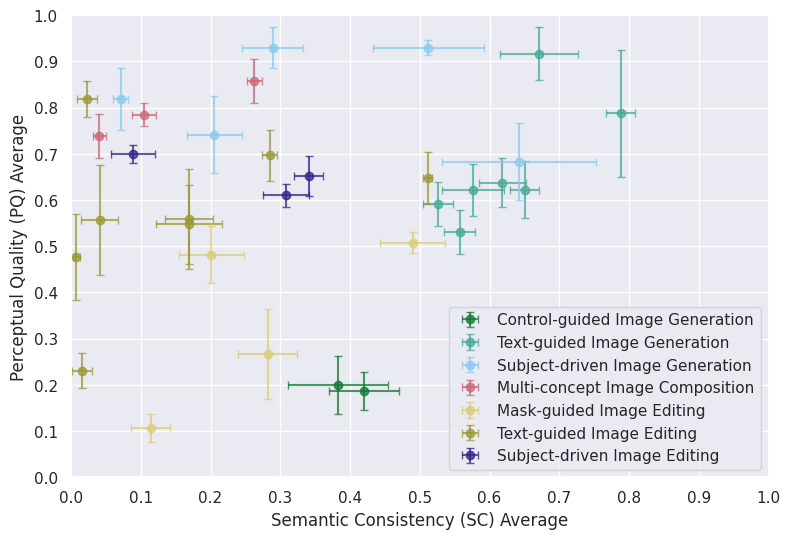

In [12]:
fig = plt.figure(figsize=(9, 6))
final = grab_dataframes()
for task_name in final.keys():
    result = final[task_name]
    if len(result) >= 1:
        result = get_final_dicts(result, apply_average=True)
        SC_avg_list = []
        PR_avg_list = []
        SC_std_list = []
        PR_std_list = []
        for model_name in result.keys():
            if model_name == "Imagic":
                continue
            SC_avg_list.append(result[model_name]['SC_avg'])
            PR_avg_list.append(result[model_name]['PR_avg'])
            SC_std_list.append(result[model_name]['SC_std'])
            PR_std_list.append(result[model_name]['PR_std'])
        color = mapping_colors[task_name]
        task_name = mapping_names[task_name]
        plt.errorbar(SC_avg_list, PR_avg_list, xerr=SC_std_list, yerr=PR_std_list, alpha=0.75, fmt='o', label=task_name, color=color, capsize=3)

#plt.title("Model performance in each task")
plt.xlabel("Semantic Consistency (SC) Average")
plt.ylabel("Perceptual Quality (PQ) Average")
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend()
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
#plt.tight_layout()
plt.savefig("plot_SD.png", bbox_inches = 'tight')
plt.show()
                